In [9]:
import glob
import numpy as np
import pandas as pd
from natsort import natsorted
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline

In [10]:
import warnings
warnings.filterwarnings('ignore')

## Load data

In [11]:
def load_data(path): 
    files = glob.glob(path)
    files = natsorted(files)
    dfs_split = []
    for file in files: 
        df = pd.read_csv(file, index_col=[0,1], header=[0,1], parse_dates=True)
        dfs_split.append(df)
    
    return dfs_split

In [12]:
trial_name = 'trial44'
model = 'catboost'
dfs_X_train = load_data('../results/gefcom2014-solar/'+trial_name+'/dfs_X_train/*.csv')
dfs_X_valid = load_data('../results/gefcom2014-solar/'+trial_name+'/dfs_X_valid/*.csv')
dfs_y_train = load_data('../results/gefcom2014-solar/'+trial_name+'/dfs_y_train/*.csv')
dfs_y_valid = load_data('../results/gefcom2014-solar/'+trial_name+'/dfs_y_valid/*.csv')
dfs_y_pred_train = load_data('../results/gefcom2014-solar/'+trial_name+'/dfs_y_pred_train/*'+model+'*.csv')
dfs_y_pred_valid = load_data('../results/gefcom2014-solar/'+trial_name+'/dfs_y_pred_valid/*'+model+'*.csv')
df_X_valid = pd.concat(dfs_X_valid)
df_y_valid = pd.concat(dfs_y_valid)
df_y_pred_valid = pd.concat(dfs_y_pred_valid)

In [13]:
df_y_pred_valid.index[0], df_y_pred_valid.index[-1]

((Timestamp('2013-04-01 01:00:00'), Timestamp('2013-04-01 01:00:00')),
 (Timestamp('2014-06-30 01:00:00'), Timestamp('2014-07-01 00:00:00')))

## Plot forecast

In [14]:
def plot_quantile_forecast(df_pred, df_y, start_time, end_time, df_clearsky=None, df_physical=None, df_radiation=None):
    df_plot_pred = df_pred.reset_index(level=0, drop=True)[start_time:end_time].astype(float)
    df_plot_true = df_y.reset_index(level=0, drop=True)[start_time:end_time].astype(float)
    
    if df_radiation is not None: 
        nrows=2
    else:
        nrows=1
        
    fig, ax = plt.subplots(nrows=nrows, figsize=(15,5))
    if not isinstance(ax, np.ndarray): ax = [ax]
    quantiles = np.arange(1,100)
    alphas = np.linspace(0.01, 0.1, int(len(quantiles)/2))
    for i in range(int(len(quantiles)/2)):
        ax[0].fill_between(df_plot_pred.index, 
                        df_plot_pred['quantile'+str(i+1)].values, 
                        df_plot_pred['quantile'+str(99-i)].values,
                        color='b', linewidth=0.0, alpha=alphas[i])
    ax[0].plot(df_plot_pred.index, df_plot_pred['quantile50'].values, 'k--', label='median')
    
    if df_clearsky is not None:
        df_plot_clearsky = df_clearsky.reset_index(level=0, drop=True)[start_time:end_time].astype(float)
        ax[0].plot(df_plot_clearsky.index, df_plot_clearsky.values, '--', color='red', label='clearsky')
    if df_physical is not None:
        df_plot_physical = df_physical.reset_index(level=0, drop=True)[start_time:end_time].astype(float)
        ax[0].plot(df_plot_physical.index, df_plot_physical.values, '--', color='green', label='physical')
    if df_radiation is not None:
        df_radiation = df_radiation.reset_index(level=0, drop=True)[start_time:end_time].astype(float)
        ax[1].plot(df_radiation.index, df_radiation.values, '-', color='orange', label='median')
        
    ax[0].plot(df_plot_true.index, df_plot_true.values, color='orange', label='real')
    ax[0].legend()
    ax[0].xaxis.set_major_locator(mdates.DayLocator(interval=1))
    ax[1].xaxis.set_major_locator(mdates.DayLocator(interval=1))

    

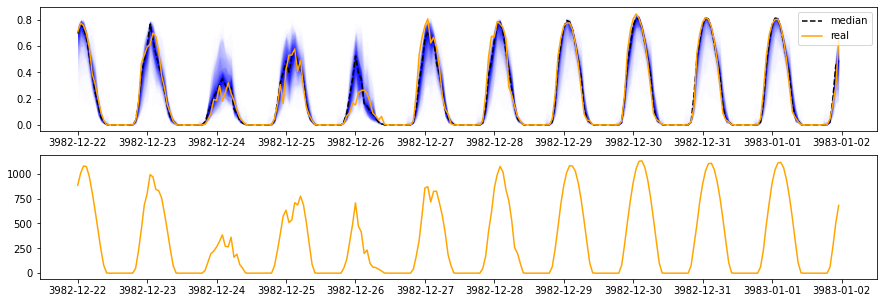

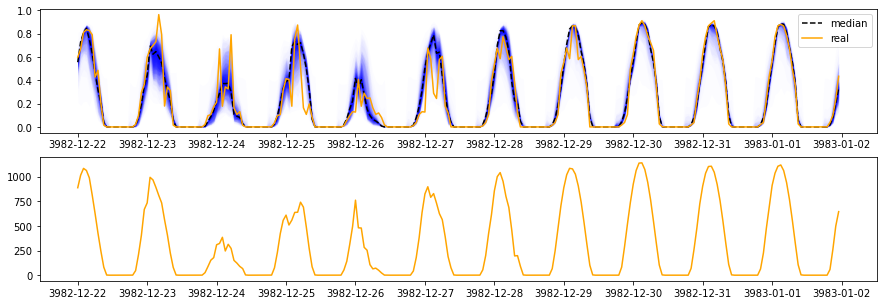

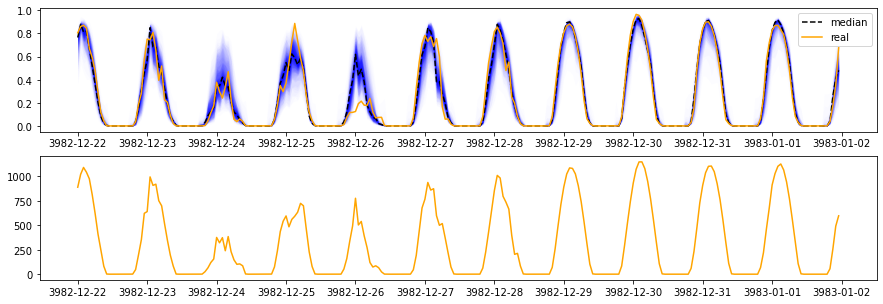

In [15]:
start_time = '2013-12-21'
end_time = '2013-12-31'
plot_quantile_forecast(df_y_pred_valid['1'], df_y_valid['1'], start_time, end_time, df_radiation=df_X_valid['1']['VAR169'])
plot_quantile_forecast(df_y_pred_valid['2'], df_y_valid['2'], start_time, end_time, df_radiation=df_X_valid['2']['VAR169'])
plot_quantile_forecast(df_y_pred_valid['3'], df_y_valid['3'], start_time, end_time, df_radiation=df_X_valid['3']['VAR169'])

## Plot MAE

<AxesSubplot:xlabel='valid_datetime'>

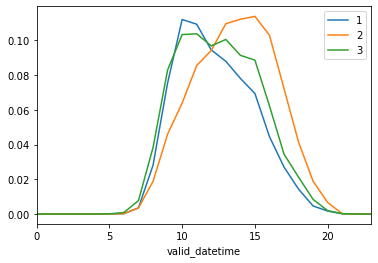

In [19]:
df_pred = df_y_pred_valid.copy()
df_pred = df_pred.loc[:, (slice(None), 'quantile50')]
df_pred.index = df_pred.index.droplevel(0)
df_pred.columns = df_pred.columns.droplevel(1)

df_y = df_y_valid.copy()
df_y.index = df_y.index.droplevel(0)
df_y.columns = df_y.columns.droplevel(1)

df_error = df_pred-df_y
df_error = df_error.tz_localize('UTC').tz_convert('Australia/Melbourne')
df_mae = df_error.abs().groupby(df_error.index.hour).mean()
df_mae.plot()

## Plot absolute error over year

In [20]:
def plot_map_error(df_error):
    error = df_error.groupby([df_error.index.hour, df_error.index.dayofyear]).mean().unstack()
    
    plt.figure(figsize=(20,5))
    plt.imshow(error, cmap='viridis', aspect='auto')
    plt.colorbar()
    plt.show()

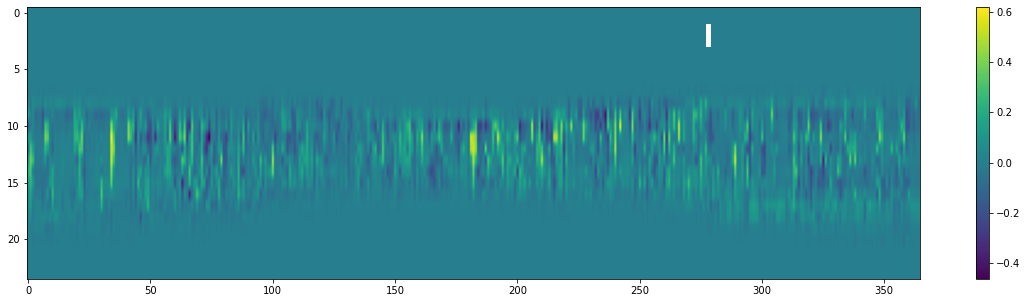

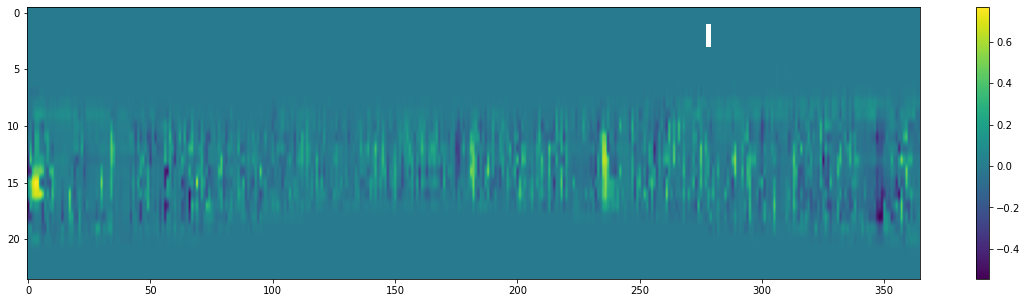

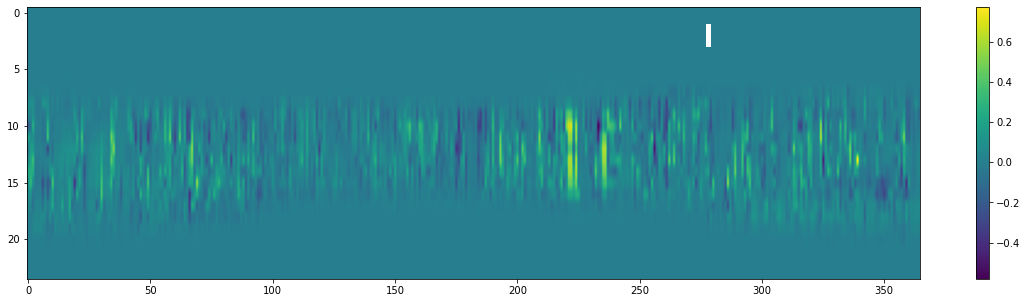

In [21]:
plot_map_error(df_error['1'])
plot_map_error(df_error['2'])
plot_map_error(df_error['3'])

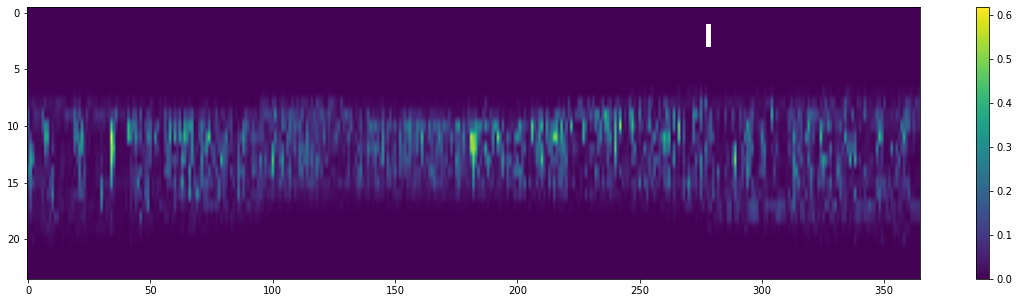

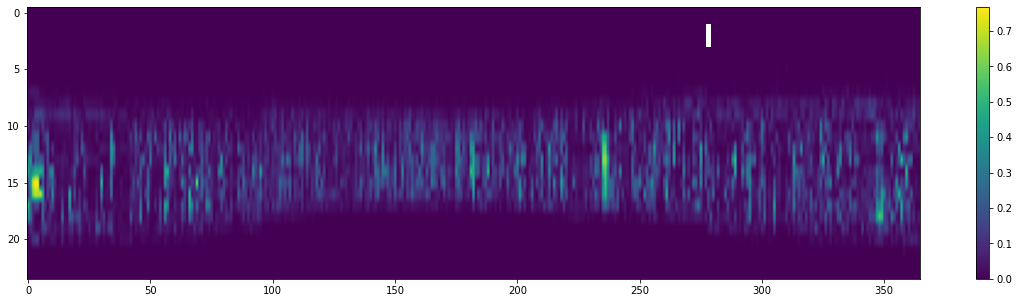

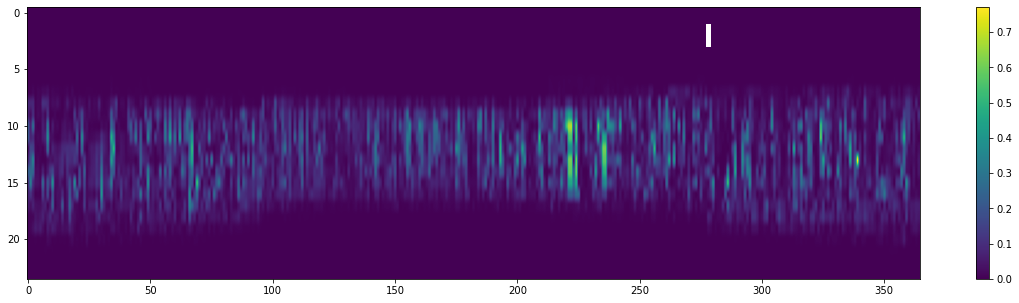

In [22]:
plot_map_error(df_error['1'].abs())
plot_map_error(df_error['2'].abs())
plot_map_error(df_error['3'].abs())

## Scatter plot

In [403]:
def plot_scatters(dfs_y_pred_train_split, dfs_y_train_split, site_name, dfs_y_pred_test_split=None, dfs_y_test_split=None):
    fig, ax = plt.subplots(nrows=5, ncols=3, figsize=(15,15), sharex=True, sharey=True)
    ax = ax.flatten()
    for split in range(len(dfs_y_train_split)): 
        ax[split].scatter(dfs_y_train_split[split][site_name]['POWER'], dfs_y_pred_train_split[split][site_name]['quantile50'], alpha=0.3, label='train' if split==0 else '')
        if not ((dfs_y_pred_test_split == None) and (dfs_y_test_split == None)):
            ax[split].scatter(dfs_y_test_split[split][site_name]['POWER'], dfs_y_pred_test_split[split][site_name]['quantile50'], alpha=0.3, label='test' if split==0 else '')
        ax[split].set_title('Split: {0}'.format(split))
        if split==0: ax[split].legend()

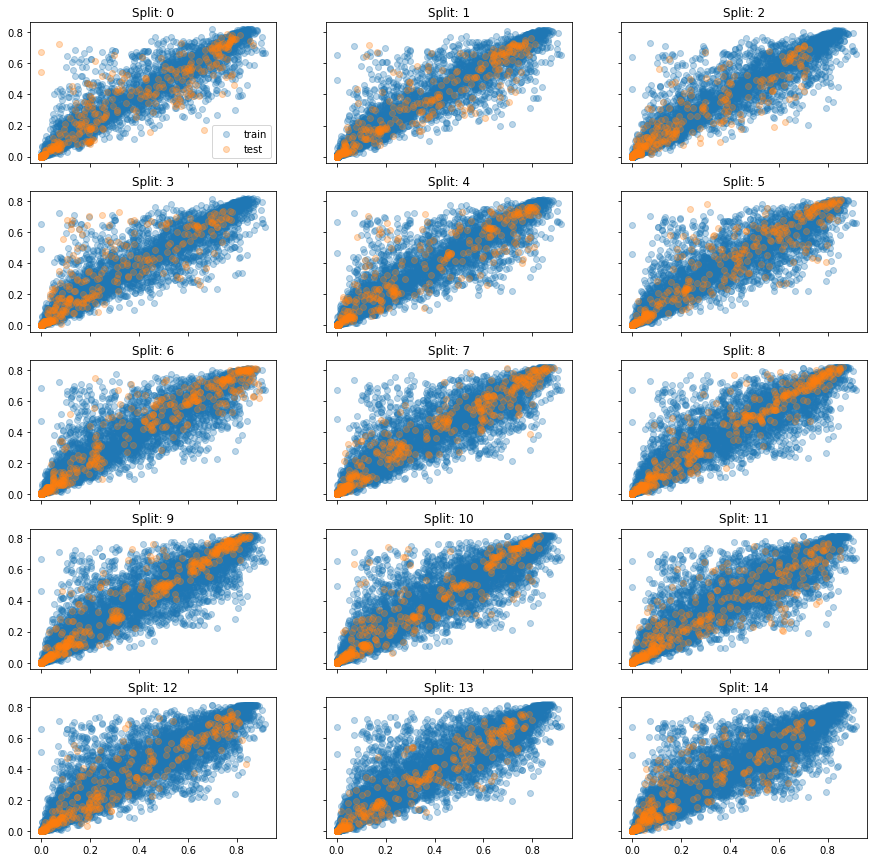

In [404]:
plot_scatters(dfs_y_pred_train, dfs_y_train, site_name='1',  dfs_y_pred_test_split=dfs_y_pred_valid, dfs_y_test_split=dfs_y_valid)

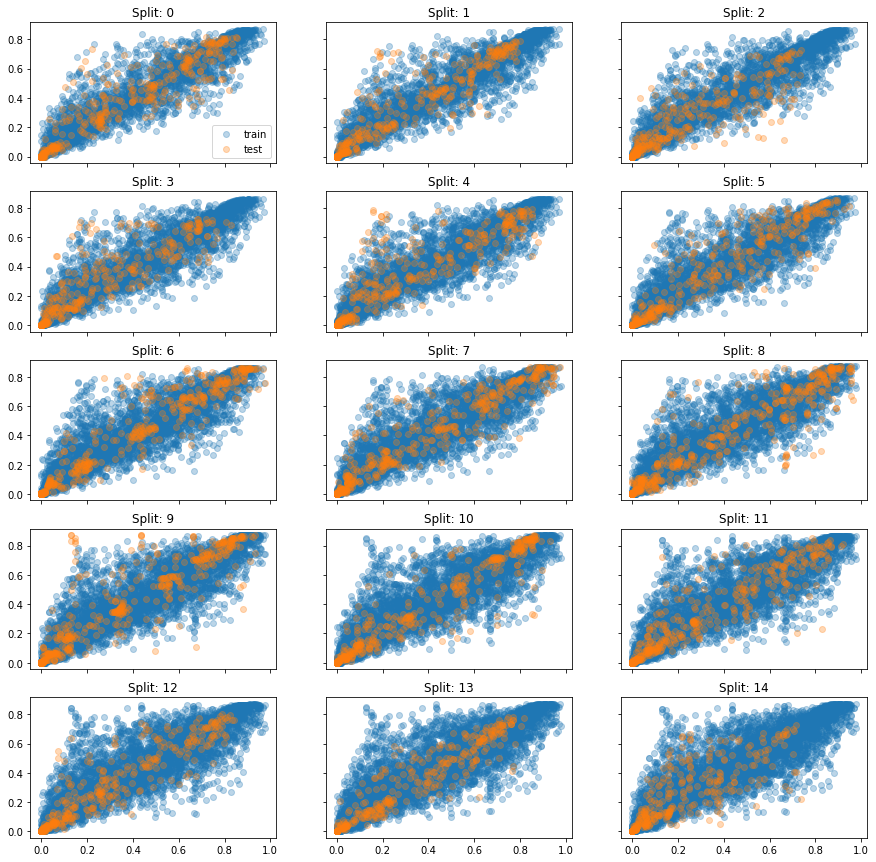

In [350]:
plot_scatters(dfs_y_pred_train, dfs_y_train, site_name='2',  dfs_y_pred_test_split=dfs_y_pred_valid, dfs_y_test_split=dfs_y_valid)

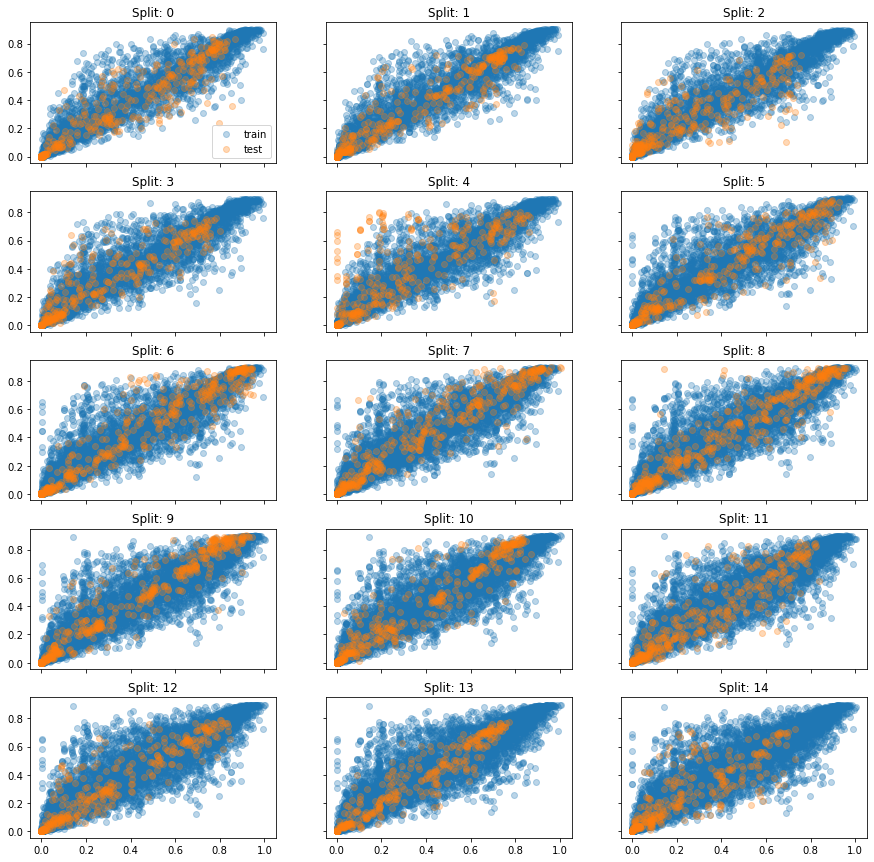

In [353]:
plot_scatters(dfs_y_pred_train, dfs_y_train, site_name='3',  dfs_y_pred_test_split=dfs_y_pred_valid, dfs_y_test_split=dfs_y_valid)

## Plot distributions

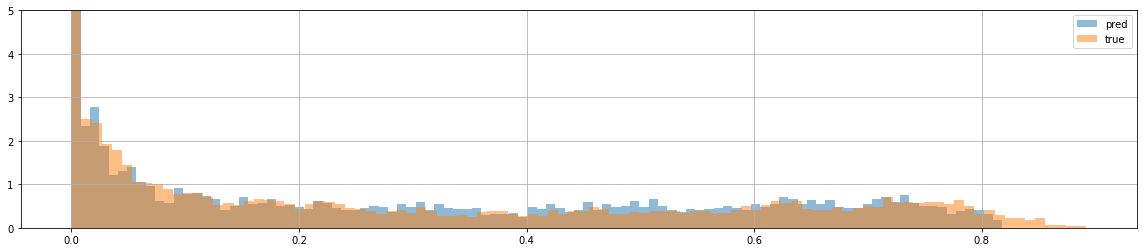

In [359]:
df_pred['1'].hist(bins=100, density=True, alpha=0.5, label='pred', figsize=(20,4))
df_y['1'].hist(bins=100, density=True, alpha=0.5, label='true')
plt.ylim([0,5]);
plt.legend()

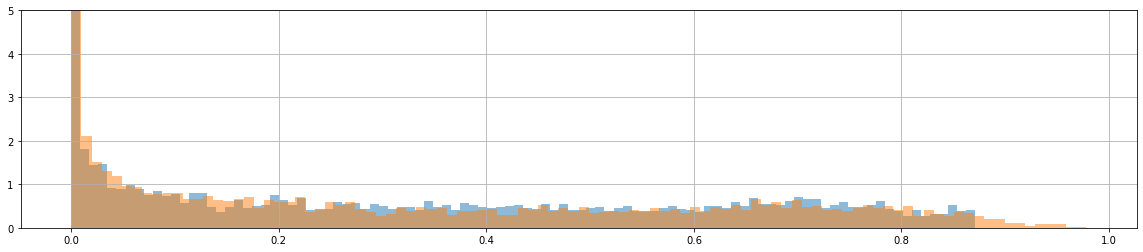

In [360]:
df_pred['2'].hist(bins=100, density=True, alpha=0.5, label='pred', figsize=(20,4))
df_y['2'].hist(bins=100, density=True, alpha=0.5, label='true')
plt.ylim([0,5]);

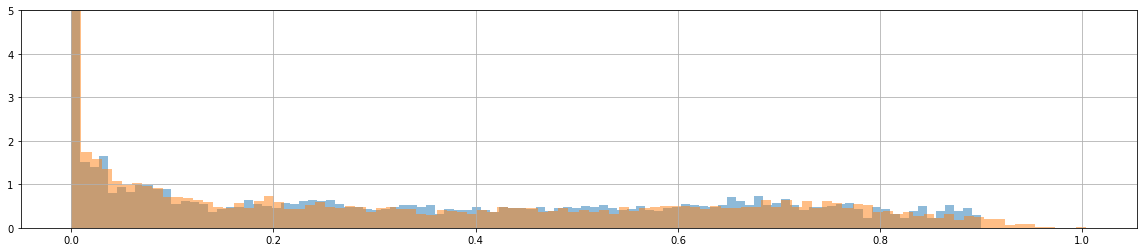

In [361]:
df_pred['3'].hist(bins=100, density=True, alpha=0.5, label='pred', figsize=(20,4))
df_y['3'].hist(bins=100, density=True, alpha=0.5, label='true')
plt.ylim([0,5]);